# Konstrukcja diagramu Woronoja jako grafu dualnego do triangulacji Delaunaya wyznaczonej algorytmem Bowyera-Watsona

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()
        plt.gca().set_aspect('equal')


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        #ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        #ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        #b_add_line = Button(ax_add_line, 'Dodaj linię')
        #b_add_line.on_clicked(self.callback.add_line)
        #b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        #b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

# Rozwiązanie

Poniżej zaimplementowano algorytm Bowyera-Watson wyznaczający triangulację Delaunaya zbioru punktów, a następnie przekształcający uzyskaną triangulację w diagram Woronoja. Zaimplementowano również wizualizację algorytmu, która prezentuje jego kolejne etapy. Dane wejściowe w postaci listy punktów można wprowadzić ręcznie korzystając z myszki lub wygenerować dowolną ilość losowych punktów z zadanego obszaru.

In [3]:
%matplotlib notebook

#### Funkcje do wprowadzania, zapisywania i wczytywania danych wejściowych
Możliwe jest zadanie punktów za pomocą myszki oraz zapisanie wprowadzonego układu do pliku .json. Możliwe jest również wczytanie zbioru punktów z pliku .json oraz wygenerowanie dowolnej liczby losowych punktów z zadanego obszaru.


In [4]:
import random
import json
from math import cos
from math import sin
from math import pi
from math import sqrt


# Generate N random points limited to a region [a;b]x[a;b]. Function returns
# list of tuples (x,y) representing cartesian coordinates of points.
def genRndPoints(N, a, b):
    points = []
    for i in range(N):
        x, y = random.uniform(a, b), random.uniform(a, b)
        points.append((x, y))
    return points


def saveDrawnPoints(file_name="points.json"):
    savePlot = Plot([plot_points.get_added_elements()])

    if len(plot_points.get_added_points()) == 0:
        print(
            "\x1b[5;30;41m !!! Nieprawidłowe dane. Nie narysowano żadnego punktu !!! \x1b[0m ")
        return None
    else:
        with open(file_name, "w") as json_file:
            json_file.write(savePlot.toJson())

        with open(file_name, "r") as json_file:
            data = json.load(json_file)[0]["points"][0]
        print("\x1b[5;30;42m ✓ Pomyślnie zapisano dane ✓ \x1b[0m ")


# Input set of points from .json file. Assuming correct input. Function returns
# list of tuples (x,y) representing cartesian coordinates of points.
def loadPoints(json_file_path):
    with open(json_file_path, "r") as json_file:
        data = json.load(json_file)[0]["points"][0]

    points = []
    for p in data:
        points.append((p[0], p[1]))

    return points


#### Wprowadzanie zbioru punktów za pomocą myszki

<IPython.core.display.Javascript object>


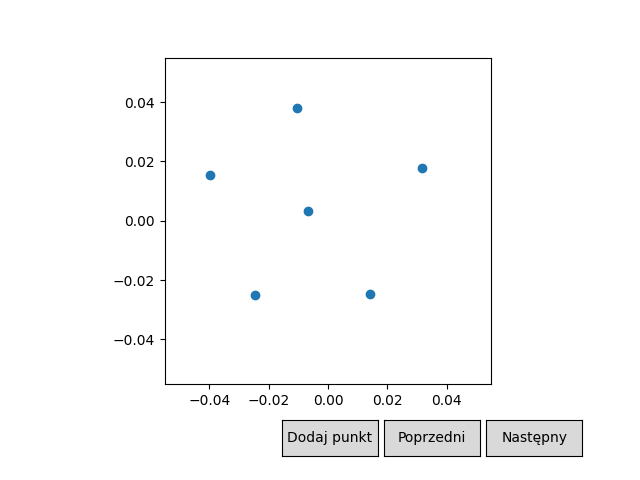

In [196]:
plot_points = Plot([Scene()])
plot_points.draw()

In [197]:
# Save drawn points (you need to run this cell in order to save the set of points drawn above)
saveDrawnPoints("test.json")

 ✓ Pomyślnie zapisano dane ✓  


#### Algorytm Bowyera-Watsona
Poniżej zaimplementowano algorytm Bowyera-Watsona wyznaczający triangulację zadanego zbioru punktów, a następnie dualny do niej diagram Woronoja. Ideę algorytmu można przedstawić w postaci elementarnego pseudokodu
```
funkcja BowyerWatson:
    points := lista zadanych punktów
    triangles := pusty zbiór trójkątów triangulacji
    
    Znajdź super-prostokąt pokrywający całkowicie chmurę punktów.
    Dodaj do triangles dwa super-trójkąty powstałe z podziału super-prostokąta jedną z jego przekątnych.
    
    Dla każdego punktu p z points:
        Znajdź wszystkie trójkąty T, takie że okrąg opisany na T zawiera punkt p i dodaj je do zbioru badTriangles.
        
        Znajdź krawędzie wielokąta, który powstałby po usunięciu trójkątów z badTriangles i dodaj je do zbioru polygon.
        
        Usuń z triangles wszystkie trójkąty znajdujące się w badTriangles.
        
        Dokonaj triangulacji powstałej wielokątnej wnęki polygon.
    
    Usuń z triangles wszystkie trójkąty, które zawierają wierzchołek super-trójkąta.
    
    Oblicz diagram Woronoja jako graf dualny do triangulacji Delaunaya zawartej w triangles.
```
Poniżej opisano dokładnie implementację kolejnych fragmentów powyższego pseudokodu.
1. **Wykorzystane struktury danych**
* Wejściowe punkty są przechowywane w liście points, która zawiera pary typu (float,float) określające współrzędne kolejnych punktów
* Struktura triangles przechowuje trójki postaci (int,int,int) określające wierzchołki trójkąta jako indeksy punktów w liście points. Struktura triangles została zaimplementowana jako pythonowy set().
* Struktura edges przechowuje pary typu key-value, gdzie kluczami są pary typu (int,int) określające krawędź triangulacji jako indeksy punktów w liście points, natomiast wartościami są zbiory zawierające trójkąty, które zawierają krawędź będąca kluczem. Trójkąty te są reprezentowane tak jak w strukturze triangles tj. w postaci trójek typu (int,int,int). Struktura edges została zaimplementowana jako pythonowy słownik.
2. **Konstrukcja super-prostokąta pokrywającego zadaną chmurę punktów i super-trójkątów**
* Super-prostokąt obliczamy poprzez znalezienie maksymalnej i minimalnej współrzędnej x i y chmury punktów, obliczenie wielkości l:=max(|y_max-y_min|, |x_max-x_min|), a następnie odpowiednio dodanie i odjęcie l do/od x_max, y_max i x_min, y_min. Parametr l określa wielkość obszaru, do którego ograniczamy obliczany diagram Woronoja.
3. **Poszukiwanie trójkątów, których okrąg opisany zawiera dany punkt p**
* Dla każdego trójkąta T(A,B,C) znajdującego się aktualnie w zbiorze triangles obliczamy współrzędne środka okręgu opisanego na nim centre(A,B,C) korzystając ze wzorów znajdujących się na [Wikipedii](https://en.wikipedia.org/wiki/Circumscribed_circle#Cartesian_coordinates_2) oraz promień tego okręgu korzystając ze wzoru R = a \* b \* c / (4 \* ( s \* (s-a) \* (s-b) \* (s-c) )^(1/2), gdzie a, b, c to długości boków trójkąta, a s:=(a+b+c)/2. Jeśli odległość punktu p od środka centre(A,B,C) jest mniejsza lub równa R to dodajemy trójkąt T(A,B,C) do zbioru badTriangles (badTriangles jest implementowany jako pythonowy set()). Równość sprawdzana jest przez warunek abs(dist(p,centre)-radius) < err, gdzie err to tolerancja dla zera.
4. **Poszukiwanie krawędzi wielokąta, który powstanie po usunięciu trójkątów z badTriangles**
* Dla każego trójkąta T(A,B,C) znajdującego się w zbiorze badTriangles przypisujemy a, b, c = (A,B), (B,C), (C,A), a następnie dla każdej krawędzi e z (a,b,c) obliczamy moc zbioru (edges[e] & badTriangles) - {T} (ponieważ #edges[e] <= 2 oraz złożoność znalezienia części wspólnej s&t to O(min(#s, #t)), a złożoność znalezienia różnicy s-t to O(#s), więc obliczenie mocy zbioru w powyższy sposób zajmuje O(1) operacji). Jeśli moc powyższego zbioru wynosi 0 to dana krawędź e nie jest krawędzią wspólną żadnych dwóch trójkątów ze zbioru badTriangles, czyli jest krawędzią poszukiwanego wielokąta i dodajemy ją do zbioru krawędzi polygon (polygon jest implementowany jako pythonowy set())
5. **Usuwanie nieprawidłowych trójkątów**
* Dla każdego trójkąta T(A,B,C) znajdującego się w zbiorze badTriangles przypisujemy a, b, c = (A,B), (B,C), (C,A). Usuwamy T ze zbioru triangles korzystając z metody .remove() (o złożoności czasowej O(1)), a następnie aktualizujemy strukturę edges:
    * dla każdej krawędzi e z (a,b,c) usuwamy trójkąt T ze zbioru edges[e] korzystając z metody .remove() i jeśli po usunięciu zbiór ten jest pusty usuwamy klucz e ze słownika edges korzystając z metody del (o złożoności O(1)).
6. **Triangulacja wielokątnej wnęki**
* Dla każdej krawędzi e = (q,r) dodajemy do zbioru triangles trójkąt T(p,q,r) i aktualizujemy strukturę edges:
    * przypisujemy a, b, c = (p,q), (q,r), (r,p), a następnie dla każdej krawędzi e z (a,b,c): jeśli klucz e istnieje już w edges (sprawdzamy to w O(1) korzystając z metody .get()) to dodajemy do zbioru edges[e] trójkąt T(p,q,r), natomiast jeśli klucz e nie istnieje to go tworzymy i wstawiamy do pustego zbioru edges[e] trójkąt T(p,q,r).
7. **Usuwanie trójkątów zawierających wierzchołek początkowego super-trójkąta**
* Dla każdego trójkąta T(A,B,C) znajdującego się w zbiorze triangles sprawdzamy, czy A lub B lub C są wierzchołkami super-trójkąta. Jeśli tak to dodajemy T do zbioru toRemove. Następnie dla każdego trójkąta T ze zbioru toRemove usuwamy T ze zbioru triangles korzystając z metody .remove().
8. **Obliczenie diagramu Woronoja dualnego do wyznaczonej triangulacji Delaunaya**
* Diagram Woronoja jest reprezentowany przez listę voronoi zawierającą krawędzie go tworzące. Dla każdej krawędzi e będącej kluczem w edges przypisujemy Ts = edges[e] & triangles (O(1)). 
    * Jeśli #Ts = 2 to krawędź e jest krawędzią wspólną dwóch trójkątów T1(A1,B1,C1), T2(A2,B2,C2) zatem do listy voronoi dodajemy krawędź [centre(A1,B1,C1), centre(A1,B2,C2)]. 
    * Jeśli #Ts = 1 to krawędź e należy do otoczki wypukłej chmury punktów i krawędź diagramu Woronoja jest fragmentem prostej prostopadłej do e. W celach wizualizacji możemy jednak utworzyć w tym przypadku krawędź pomiędzy trójkątem T1 z Ts i trójkątem T2 zawierającym wierzchołek super-trójkąta, przy czym oba trójkąty T1 i T2 znajdują się w zbiorze edges[e].

Implementacja algorytmu zakłada nietrywialne dane wejściowe, tj. zakładamy len(points) >= 3.

In [5]:
# Define Euclidean metric on R^2
def d(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return (x2-x1)**2 + (y2-y1)**2


# Calculate radius of a circumcircle of a triangle ABC
def radius(A, B, C):
    a, b, c = sqrt(d(A, B)), sqrt(d(B, C)), sqrt(d(C, A))
    s = (a+b+c)/2
    return a * b * c/(4 * sqrt(s * (s-a) * (s-b) * (s-c)))


# Calculate centre of a circumcircle of a triangle ABC
def centre(A, B, C):
    Ax, Ay = A
    Bx, By = B
    Cx, Cy = C
    D = 2*(Ax*(By-Cy)+Bx*(Cy-Ay)+Cx*(Ay-By))
    ox = 1/D * ((Ax**2+Ay**2)*(By-Cy)+(Bx**2+By**2) * (Cy-Ay)+(Cx**2+Cy**2)*(Ay-By))
    oy = 1/D * ((Ax**2+Ay**2)*(Cx-Bx)+(Bx**2+By**2) * (Ax-Cx)+(Cx**2+Cy**2)*(Bx-Ax))
    return (ox, oy)


In [6]:
def BowyerWatson(points):  # O(n^2)
    n = len(points)
    err = 10**-8  # tolerance for 0 i.e. abs(x-y)<err => x =~ y

    # Construct a super-rectangle which completely covers the set of points and
    # an initial triangulation consisting of two super-triangles
    x_max, y_max = max(points, key=lambda x: x[0])[0], max(points, key=lambda x: x[1])[1]
    x_min, y_min = min(points, key=lambda x: x[0])[0], min(points, key=lambda x: x[1])[1]
    l = max(abs(y_max-y_min), abs(x_max-x_min))
    x_max += l
    y_max += l
    x_min -= l
    y_min -= l
    points = points[:] + [(x_min, y_min), (x_min, y_max),(x_max, y_max), (x_max, y_min)]

    superT1, superT2 = (n, n+1, n+2), (n, n+2, n+3)
    triangles = {superT1, superT2}
    edges = {(n, n+1): {superT1}, (n+1, n+2): {superT1}, (n+2, n+3): {superT2},
             (n+3, n): {superT2}, (n+2, n): {superT1, superT2}}

    for p in range(n):
        # Find all triangles such that their circumcircle contains point p. We
        # will call them 'bad' triangles
        badTriangles = set()
        for T in triangles:
            A, B, C = points[T[0]], points[T[1]], points[T[2]]
            d2, r2 = d(points[p], centre(A, B, C)), radius(A, B, C)**2
            if d2 < r2 or abs(d2 - r2) < err:
                badTriangles.add(T)

        # Find the boundary of the polygonal 'hole' which would be created after
        # removing all bad triangles
        polygon = set()
        for T in badTriangles:
            a, b, c = (T[0], T[1]), (T[1], T[2]), (T[2], T[0])
            for e in (a, b, c):
                Ts = edges[e] if edges.get(e) != None else edges[e[::-1]]
                if len((Ts & badTriangles) - {T}) == 0:
                    polygon.add(e)

        # Remove bad triangles
        for T in badTriangles:
            a, b, c = (T[0], T[1]), (T[1], T[2]), (T[2], T[0])
            triangles.remove(T)
            for e in (a, b, c):
                e = e if edges.get(e) != None else e[::-1]
                edges[e].remove(T)
                if len(edges[e]) == 0:
                    del edges[e]

        # Triangulate the interior of the polygonal hole
        for e in polygon:
            T = (p, e[0], e[1])
            triangles.add(T)
            a, b, c = (T[0], T[1]), (T[1], T[2]), (T[2], T[0])
            for e in (a, b, c):
                if edges.get(e) != None:
                    edges[e].add(T)
                elif edges.get(e[::-1]) != None:
                    edges[e[::-1]].add(T)
                else:
                    edges[e] = {T}

    # Remove triangles which contain a vertex from the initial super-triangle
    toRemove = set()
    for T in triangles:
        for p in (T[0], T[1], T[2]):
            if p in (n, n+1, n+2, n+3):
                toRemove.add(T)
    for T in toRemove:
        triangles.remove(T)

    # Compute Voronoi diagram dual to the computed Delaunay triangulation, O(n)
    voronoi = []
    for e in edges:
        Ts = edges[e] & triangles
        if len(Ts) == 2:
            T1, T2 = Ts.pop(), Ts.pop()
        elif len(Ts) == 1:
            T1, T2 = edges[e].pop(), edges[e].pop()
        else:
            T1, T2 = None, None
        if T1 != None and T2 != None:
            A1, B1, C1 = points[T1[0]], points[T1[1]], points[T1[2]]
            A2, B2, C2 = points[T2[0]], points[T2[1]], points[T2[2]]
            voronoi.append([centre(A1, B1, C1), centre(A2, B2, C2)])

    return triangles, voronoi


#### Graficzna prezentacja wyniku działania algorytmu Bowyera-Watsona
Funkcja showResults przyjmuje listę punktów i rysuje wynik działania algorytmu Bowyera-Watsona. W zależności od ustawionych parametrów (showTriangulation, showVoronoi, showCircles, showCentres) pokazuje odpowiednio: obliczoną triangulację zbioru punktów, diagram Woronoja zbioru punktów, okręgi opisane na trójkątach z triangulacji oraz ich środki.

Legenda
* Czarne punkty - wprowadzony zbiór punktów
* Czarne krawędzie - krawędzie triangulacji
* Czerwone punkty - środki okręgów opisanych na odpowiednich trójkątach z triangulacji
* Czerwone krawędzie - krawędzie diagramu Woronoja

In [7]:
import matplotlib.pyplot as plt


# Generate regular 100-sided polygon approximating a circle.
def drawCircle(O, R):
    n = 100
    lines = []
    phi, dphi = 0, 2*pi/n
    for _ in range(n+1):
        x1, y1 = O[0] + R*cos(phi), O[1] + R*sin(phi)
        x2, y2 = O[0] + R*cos(phi + dphi), O[1] + R*sin(phi + dphi)
        phi += dphi
        lines.append([(x1, y1), (x2, y2)])

    return lines


# Generate list of edges from the triangles set returned by Bowyer-Watson
# algorithm and compute their circumcircles to enhance the visualization
def drawTriangles(triangles, points):
    edges, centres, radii = set(), [], []
    for T in triangles:
        A, B, C = points[T[0]], points[T[1]], points[T[2]]
        if (A, B) not in edges and (B, A) not in edges:
            edges.add((A, B))
        if (B, C) not in edges and (C, B) not in edges:
            edges.add((B, C))
        if (C, A) not in edges and (A, C) not in edges:
            edges.add((C, A))
        centres.append(centre(A, B, C))
        radii.append(radius(A, B, C))
    edges = [[p, q] for p, q in edges]
    
    return edges, centres, radii


def showResults(points, showTriangulation = True, showVoronoi = True, showCircles = True, showCentres = True):    
    triangles, voronoi = BowyerWatson(points)
    edges, centres, radii = drawTriangles(triangles, points)
    P, lines = [PointsCollection(points, marker=".", color="black")], []
    
    if showTriangulation:
        lines = lines[:] + [LinesCollection(edges, color="black", linewidth=0.75)]
    if showVoronoi:
        lines = lines[:] + [LinesCollection(voronoi, color="red", linewidth=0.75)]
    if showCircles:
        lines = lines[:] + [LinesCollection(drawCircle(centres[i], radii[i]), color="grey", linestyle="--", linewidth=0.5) for i in range(len(centres))]
    if showCentres:
        P = P[:] + [PointsCollection(centres, color="red", marker=".")]
    
    # Show plot
    plot = Plot(points=P, lines=lines)
    plot.draw()
    
    # Fix plot
    x_max, y_max = max(points, key=lambda x: x[0])[0], max(points, key=lambda x: x[1])[1]
    x_min, y_min = min(points, key=lambda x: x[0])[0], min(points, key=lambda x: x[1])[1]
    a = max(x_max-x_min, y_max-y_min)
    padding = 0.15*a
    plt.axis([x_min - padding, x_max + padding, y_min - padding, y_max + padding])
    
    return None


<IPython.core.display.Javascript object>


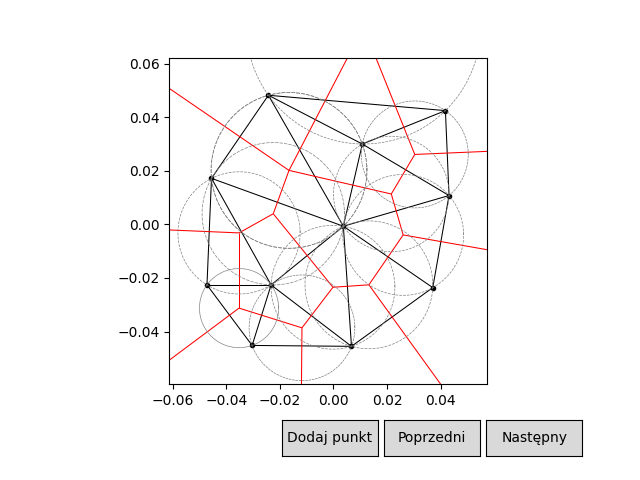

In [8]:
#points = [(cos(i*pi/5),sin(i*pi/5)) for i in range(10)]
#points = [(1.80901699437,0.59778525229), (1.30901699437,0.95105651629), (0.40901699437,0.55105651629)]
#points = genRndPoints(40, -10, 10)
#points = [(0,0), (0,1), (1,0), (1,1)]
points = loadPoints("points.json")

showResults(points, showTriangulation=True, showVoronoi=True, showCircles=True, showCentres=False)

#### Wizualizacja etapów działania algorytmu
Poniżej zaimplementowano wizualizację kolejnych etapów działania opisanego wyżej algorytmu Bowyera-Watsona. Pierwsza część wizualizacji prezentuje algorytm wyznaczania triangulacji Delaunaya zadanej chmury punktów, natomiast druga - przekształcenie uzyskanej triangulacji w dualny do niej diagram Woronoja. Poniżej zamieszczono krótki opis elementów zastosowanych w wizualizacji oraz ich oznaczeń.
1. **Wyznaczenie triangulacji Delaunaya**
* Kolorem zielonym zaznaczony jest aktualnie rozpatrywany punkt z chmury.
* Kolorem czerwonym oznaczone są krawędzie nieprawidłowych trójkątów, których okręgi opisane zawierają aktualnie rozpatrywany punkt. Do wizualizacji dodano również rysowanie okręgów opisanych, aby na bieżąco sprawdzać warunek zawierania się punktu wewnątrz okręgu.
* Kolorem niebieskim oznaczone są krawędzie wyznaczonej wielokątnej wnęki.
2. **Usunięcie trójkątów zawierających wierzchołek super-trójkąta**
* Kolorem czerwonym zaznaczono krawędzie trójkątów zawierających wierzchołek super-trójkąta.
3. **Przekształcenie triangulacji Delaunaya w dualny do niej diagram Woronoja**
* Kolorem zielonym zaznaczona jest aktualnie rozpatrywana krawędź triangulacji.
* Kolorem niebieski zaznaczone są trójkąty, które zawierają aktualnie rozpatrywaną krawędź.
* Czerwoną linią przerywaną rysowane są okręgi opisane na niebieskich trójkątach, a czerwone odcinki określają krawędzie diagramu Woronoja (linią przyrywaną zaznaczono krawędź aktualnie dodawaną). 

In [9]:
def VisualBowyerWatson(points):
    n = len(points)
    err = 10**-8  # tolerance for 0 i.e. abs(x-y)<err => x =~ y
    
    #===========================================================
    Scenes = [Scene(points = [PointsCollection(points, color="black", marker=".")])]
    #===========================================================
    
    # Construct a super-rectangle which completely covers the set of points and
    # an initial triangulation containing two super-triangles
    x_max, y_max = max(points, key=lambda x: x[0])[0], max(points, key=lambda x: x[1])[1]
    x_min, y_min = min(points, key=lambda x: x[0])[0], min(points, key=lambda x: x[1])[1]
    l = max(abs(y_max-y_min), abs(x_max-x_min))
    x_max += l
    y_max += l
    x_min -= l
    y_min -= l
    points = points[:] + [(x_min, y_min), (x_min, y_max),(x_max, y_max), (x_max, y_min)]

    superT1, superT2 = (n, n+1, n+2), (n, n+2, n+3)
    triangles = {superT1, superT2}
    edges = {(n, n+1): {superT1}, (n+1, n+2): {superT1}, (n+2, n+3): {superT2},
             (n+3, n): {superT2}, (n+2, n): {superT1, superT2}}
    
    #===========================================================
    Scenes.append(Scene(points = [PointsCollection(points, color="black", marker=".")],
                        lines = [LinesCollection(drawTriangles(triangles, points)[0], linestyle="--", linewidth=0.5, color="grey")]))
    #===========================================================
    
    for p in range(n):
        
        #===========================================================
        Scenes.append(Scene(points = [PointsCollection(points, color="black", marker="."), PointsCollection([points[p]], color="green", marker="o")],
                            lines = [LinesCollection(drawTriangles(triangles, points)[0], linewidth=0.75, color="black")]))
        #===========================================================
        
        # Find all triangles such that their circumcircle contains point p. We
        # will call them 'bad' triangles
        badTriangles = set()
        for T in triangles:
            A, B, C = points[T[0]], points[T[1]], points[T[2]]
            d2, r2 = d(points[p], centre(A, B, C)), radius(A, B, C)**2
            if d2 < r2 or abs(d2 - r2) < err:
                badTriangles.add(T)
        
        #===========================================================
        E, C, R = drawTriangles(badTriangles, points)
        Scenes.append(Scene(points = [PointsCollection(points, color="black", marker="."), PointsCollection([points[p]], color="green", marker="o")],
                            lines = [LinesCollection(drawTriangles(triangles, points)[0], linewidth=0.75, color="black"),LinesCollection(E, linewidth=1, color="red")] + [LinesCollection(drawCircle(C[i], R[i]), linewidth=0.5, linestyle="--", color="red") for i in range(len(C))]))
        #===========================================================

        # Find the boundary of the polygonal 'hole' which would be created after
        # removing all bad triangles
        polygon = set()
        for T in badTriangles:
            a, b, c = (T[0], T[1]), (T[1], T[2]), (T[2], T[0])
            for e in (a, b, c):
                Ts = edges[e] if edges.get(e) != None else edges[e[::-1]]
                if len((Ts & badTriangles) - {T}) == 0:
                    polygon.add(e)
        
        #===========================================================
        E, C, R = drawTriangles(badTriangles, points)
        Scenes.append(Scene(points = [PointsCollection(points, color="black", marker="."), PointsCollection([points[p]], color="green", marker="o")],
                            lines = [LinesCollection(drawTriangles(triangles, points)[0], linewidth=0.75, color="black"), LinesCollection(E, linewidth=1, color="red"),LinesCollection([[points[p],points[q]] for p,q in polygon], linewidth=1, color="blue")]))
        #===========================================================
        
        # Remove bad triangles
        for T in badTriangles:
            a, b, c = (T[0], T[1]), (T[1], T[2]), (T[2], T[0])
            triangles.remove(T)
            for e in (a, b, c):
                e = e if edges.get(e) != None else e[::-1]
                edges[e].remove(T)
                if len(edges[e]) == 0:
                    del edges[e]
        
        #===========================================================
        Scenes.append(Scene(points = [PointsCollection(points, color="black", marker="."), PointsCollection([points[p]], color="green", marker="o")],
                            lines = [LinesCollection(drawTriangles(triangles, points)[0], linewidth=0.75, color="black"), LinesCollection([[points[p],points[q]] for p,q in polygon], linewidth=1, color="blue")]))
        #===========================================================
        
        # Triangulate the interior of the polygonal hole
        for e in polygon:
            T = (p, e[0], e[1])
            triangles.add(T)
            a, b, c = (T[0], T[1]), (T[1], T[2]), (T[2], T[0])
            for e in (a, b, c):
                if edges.get(e) != None:
                    edges[e].add(T)
                elif edges.get(e[::-1]) != None:
                    edges[e[::-1]].add(T)
                else:
                    edges[e] = {T}
                    
        #===========================================================
        Scenes.append(Scene(points = [PointsCollection(points, color="black", marker="."), PointsCollection([points[p]], color="green", marker="o")],
                            lines = [LinesCollection(drawTriangles(triangles, points)[0], linewidth=0.75, color="black"), LinesCollection([[points[p],points[q]] for p,q in polygon], linewidth=1, color="blue")]))
        
        Scenes.append(Scene(points = [PointsCollection(points, color="black", marker="."), PointsCollection([points[p]], color="green", marker="o")],
                            lines = [LinesCollection(drawTriangles(triangles, points)[0], linewidth=0.75, color="black")]))
        #===========================================================
    
    #===========================================================
    Scenes.append(Scene(points = [PointsCollection(points, color="black", marker=".")],
                        lines = [LinesCollection(drawTriangles(triangles, points)[0], linewidth=0.75, color="black")]))
    #===========================================================
    
    # Remove triangles which contain a vertex from the initial super-triangle
    toRemove = set()
    for T in triangles:
        for p in (T[0], T[1], T[2]):
            if p in (n, n+1, n+2, n+3):
                toRemove.add(T)
    for T in toRemove:
        triangles.remove(T)
    
    #===========================================================
    Scenes.append(Scene(points = [PointsCollection(points, color="black", marker=".")],
                        lines = [LinesCollection(drawTriangles(triangles, points)[0], linewidth=0.75, color="black"), LinesCollection(drawTriangles(toRemove, points)[0], linewidth=1, color="red")]))
    
    Scenes.append(Scene(points = [PointsCollection(points[:-4], color="black", marker=".")],
                        lines = [LinesCollection(drawTriangles(triangles, points)[0], linewidth=0.75, color="black")]))
    #===========================================================

    # Compute Voronoi diagram dual to the computed Delaunay triangulation, O(n)
    voronoi = []
    for e in edges:        
        Ts = edges[e] & triangles
        
        #===========================================================
        E, C, R = drawTriangles(Ts, points)
        if len(Ts) > 0:
            Scenes.append(Scene(points = [PointsCollection(points[:-4], color="black", marker="."), PointsCollection(C, color="red", marker=".")],
                                lines = [LinesCollection(drawTriangles(triangles, points)[0], linewidth=0.75, color="black"), LinesCollection(E, color="blue", linewidth=1), LinesCollection([[points[e[0]], points[e[1]]]], color="green"), LinesCollection(voronoi[:], linewidth=0.75, color="red")] + [LinesCollection(drawCircle(C[i],R[i]), color="red", linewidth=0.5, linestyle="--") for i in range(len(C))]))
        #===========================================================
        
        if len(Ts) == 2:
            T1, T2 = Ts.pop(), Ts.pop()
        elif len(Ts) == 1:
            T1, T2 = edges[e].pop(), edges[e].pop()
        else:
            T1, T2 = None, None
        if T1 != None and T2 != None:
            A1, B1, C1 = points[T1[0]], points[T1[1]], points[T1[2]]
            A2, B2, C2 = points[T2[0]], points[T2[1]], points[T2[2]]
            voronoi.append([centre(A1, B1, C1), centre(A2, B2, C2)])
            
            #===========================================================
            Scenes.append(Scene(points = [PointsCollection(points[:-4], color="black", marker=".")],
                        lines = [LinesCollection(drawTriangles(triangles, points)[0], linewidth=0.75, color="black"), LinesCollection([[points[e[0]], points[e[1]]]], color="green"), LinesCollection(voronoi[:-1], color="red", linewidth=0.75), LinesCollection([voronoi[-1]], color="red", linewidth=0.75, linestyle="--")]))
            #===========================================================
    
    #===========================================================
    Scenes.append(Scene(points = [PointsCollection(points[:-4], color="black", marker=".")],
                        lines = [LinesCollection(drawTriangles(triangles, points)[0], linewidth=0.75, color="black"), LinesCollection(voronoi[:], color="red", linewidth=0.75)]))
    
    Scenes.append(Scene(points = [PointsCollection(points[:-4], color="black", marker=".")],
                        lines = [LinesCollection(voronoi[:], color="red", linewidth=0.75)]))
    #===========================================================

    return Scenes


<IPython.core.display.Javascript object>


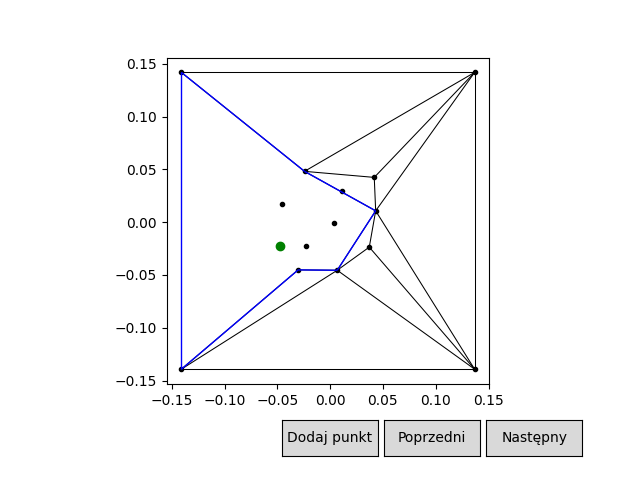

In [12]:
#points = [(1.80901699437,0.59778525229), (1.30901699437,0.95105651629), (0.40901699437,0.55105651629)]
#points = genRndPoints(10, -10, 10)
#points = [(cos(i*pi/5),sin(i*pi/5)) for i in range(10)]
#points = [(0,0), (0,1), (1,0), (1,1)]
points = loadPoints("points.json")

Scenes = VisualBowyerWatson(points)
plot = Plot(scenes=Scenes)
plot.draw()